# Oil Palm Satellite imaging

Oil palm has become a means of rapid agricultural growth in tropical areas where it thrives. This resource can be found in products ranging from shampoo to frozen foods. While increasing job availabilities, oil palm plantations have led to a dramatic rise in deforestation and loss of biodiversity. Species like the Orangutan and Sumatran Tiger are being displaced from their lands and pushed closer to extinction.

The objective here is to use high-resolution satellite imaging to automate mapping of oil palm plantations and track this rising and alarming trend.

In [1]:
import numpy as np
import os
import time
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if GPU available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("CUDA available: training on GPU")
else:
    print("CUDA unavailable: training on CPU")

CUDA available: training on GPU


In [3]:
# set image locations
train_image_dir = 'data/palm_train/'
test_image_dir = 'data/leaderboard_test_data/'
holdout_image_dir = 'data/leaderboard_holdout_data/'
has_palm_dir = 'data/palm_train/palm/palm/'
no_palm_dir = 'data/palm_train/no_palm/no_palm/'

In [4]:
# list the class sizes
print("Number of images with palm oil plantations: ", len(os.listdir(has_palm_dir)))
print("Number of images without palm oil plantations: ", len(os.listdir(no_palm_dir)))

Number of images with palm oil plantations:  936
Number of images without palm oil plantations:  14302


#### Class imbalance
Neural networks are known to be good at handling class imbalances. Nevertheless, it's worthwhile to consider this an issue and attempt to minimize. Some options include: 


- undersampling majority class in training 

- creating more minority class images by manipulating original images 

- Built in Pytorch weighted classes

### Load and transform data
Here I will add random transformations to the labeled dataset to prevent overfitting of the model. I also normalize all images to the attributes of the ImageNet data that our models are pre-trained on.

In [6]:
# set data transforms
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation([-30,30]),
                                      transforms.ColorJitter(brightness=0.5, contrast=0.75),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

# load data with ImageFolder
train_dataset = datasets.ImageFolder(train_image_dir, transform=train_transform)

holdout_dataset = datasets.ImageFolder(holdout_image_dir, transform=transform)

# competition test dataset, not to be confused with the 'test' set extracted from the training data
comp_test_dataset = datasets.ImageFolder(test_image_dir, transform=transform)

See link for representations of transformations above: 

https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll#scrollTo=BM7-0e4pzLXN

In [7]:
# create validation and test subsets from the training data
valid_size=0.2

# for optimizing purposes, I'll keep the group splits consistent
np.random.seed(2)

# split training and validation set
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]

# split a testing group out of validation set
valid_size = 0.5 # 10% validation, 10% test
num_valid = len(valid_idx)
new_split = int(np.floor(split * 0.5))
valid_idx, test_idx = valid_idx[:new_split], valid_idx[new_split:]

# define subset sampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [8]:
# defining parameters for dataloader
num_workers = 0
batch_size = 32

In [7]:
print ("Train indices length: {}\nValidation indices length: {}\nTest indices length: {} ".format(
    len(train_idx), len(valid_idx), len(test_idx)))

Train indices length: 12191
Validation indices length: 1523
Test indices length: 1524 


In [9]:
# prepare data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

### Find class distributions post- train/val/test split
Here I ensure that there is a fairly even split of minority images between the groupings (roughly 6-7% each)

In [9]:
# find class distribution

train_dist = []

for img, labels in train_loader:
    train_dist.extend(labels)

print('Class distribution of training set:')   
x=torch.stack(train_dist).numpy()
print(np.unique(x, return_counts=True))


valid_dist = []

for img, labels in valid_loader:
    valid_dist.extend(labels)

print('\nClass distribution of validation set:')
x=torch.stack(valid_dist).numpy()
print(np.unique(x, return_counts=True))


test_dist = []

for img, labels in test_loader:
    test_dist.extend(labels)

print('\nClass distribution of test set:')
x=torch.stack(test_dist).numpy()
print(np.unique(x, return_counts=True))

Class distribution of training set:
(array([0, 1], dtype=int64), array([11450,   741], dtype=int64))

Class distribution of validation set:
(array([0, 1], dtype=int64), array([1413,  110], dtype=int64))

Class distribution of test set:
(array([0, 1], dtype=int64), array([1439,   85], dtype=int64))


### Load pre-trained model

In [10]:
# define our model
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Set model parameters
Will set criterion and optimizer, as well as modify classifier layers to fit the class structure of our dataset. For example, ImageNet has 1000 classes to differentiate, here we only have 2 (true or false for palm oil plantation presence).

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
# freeze the features layers
for param in model.parameters():
    param.requires_grad = False


classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(p=0.25)),
    ('fc2', nn.Linear(4096, 4096)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(p=0.25)),
    ('output', nn.Linear(4096, 2))
]))

model.classifier = classifier

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

#### Here we can verify which parameters are unfrozen and trainable

In [14]:
params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.fc1.weight
	 classifier.fc1.bias
	 classifier.fc2.weight
	 classifier.fc2.bias
	 classifier.output.weight
	 classifier.output.bias


### The fun part: training the model

In [22]:
start_time = time.time()

# move model to cuda
if train_on_gpu:
    model.cuda()

# defining parameters for model training
n_epochs = 5
valid_loss_min = np.Inf # track changes in validation loss

# track losses over epochs
ep_train_loss = []
ep_valid_loss = []
for epoch in range(1, n_epochs+1):
    print("Epoch: ", epoch)
    train_loss = 0.0
    valid_loss = 0.0
    
    num_classes = 2
    # Calculating the number of correct predictions by the model in each class for training
    train_class_correct = list(0. for i in range(num_classes))
    # Calculate the total occurances of said class in the training set 
    train_class_total = list(0. for i in range(num_classes))
        
    # Calculating the number of correct predictions by the model in each class in validation
    val_class_correct = list(0. for i in range(num_classes))
    # Calculate the total occurances of said class in the validation set 
    val_class_total = list(0. for i in range(num_classes))
    
    
  ##### train the model #####
    model.train()
  
    for data, target in train_loader:
        # move tensors to GPU if CUDA available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # for each pass, clear the gradients of optimized variables
        optimizer.zero_grad()
        # forward pass: pass inputs into the model
        output = model(data)
        _, preds = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = preds.eq(target.data.view_as(preds))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss
        loss.backward()
        # perform single optimization step, a parameter update
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            train_class_correct[label] += correct[i].item()
            train_class_total[label] += 1
    
    # track training time
    #print('\n\nTraining time: {:10f} minutes'.format((time.time()-start_time)/60))
    
    
  ##### validate the model #####
    model.eval() # eliminates dropout
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        _, preds = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = preds.eq(target.data.view_as(preds))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate batch loss
        loss = criterion(output, target)
        # update validation loss
        valid_loss += loss.item()*data.size(0)
        for i in range(len(target.data)):
            label = target.data[i]
            val_class_correct[label] += correct[i].item()
            val_class_total[label] += 1
                
                
    # track training time
    print('\n\nTraining/Validation time: {:10f} minutes\n'.format((time.time()-start_time)/60))
    
    # calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    ep_train_loss.append(train_loss)
    ep_valid_loss.append(valid_loss)
    
    # print training/validation stats
    #print('Epoch {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

    # print training statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}, Train Accuracy (Overall): {:.6f}'.format(epoch, train_loss, (100. * np.sum(train_class_correct) / np.sum(train_class_total))))
    # print validation statistics 
    print('Epoch: {} \tValidation Loss: {:.6f}, Validation Accuracy (Overall): {:.6f}'.format(epoch, valid_loss, (100. * np.sum(val_class_correct) / np.sum(val_class_total))))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model.'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'models/vgg16-clrjitr-5ep-sgd01.pt')
        valid_loss_min = valid_loss

Epoch:  1


Training/Validation time:   4.534853 minutes

Epoch: 1 	Training Loss: 0.028295, Train Accuracy (Overall): 98.917234
Epoch: 1 	Validation Loss: 0.006298, Validation Accuracy (Overall): 98.227183
Validation loss decreased (inf --> 0.006298). Saving model.
Epoch:  2


Training/Validation time:   9.145996 minutes

Epoch: 2 	Training Loss: 0.024783, Train Accuracy (Overall): 98.917234
Epoch: 2 	Validation Loss: 0.004638, Validation Accuracy (Overall): 98.424163
Validation loss decreased (0.006298 --> 0.004638). Saving model.
Epoch:  3


Training/Validation time:  13.821759 minutes

Epoch: 3 	Training Loss: 0.026440, Train Accuracy (Overall): 98.974653
Epoch: 3 	Validation Loss: 0.005161, Validation Accuracy (Overall): 98.292843
Epoch:  4


Training/Validation time:  18.281534 minutes

Epoch: 4 	Training Loss: 0.024008, Train Accuracy (Overall): 99.040276
Epoch: 4 	Validation Loss: 0.004782, Validation Accuracy (Overall): 98.489823
Epoch:  5


Training/Validation time:  22.74182

In [13]:
### run this cell if returning to this project to skip training cell above
model.load_state_dict(torch.load('models/vgg16-5ximg-5ep-sgd01.pt'))

# double check this is the model we want to load
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
## compare model with test subset accuracy
test_loss = 0.0
class_correct = list(0.0 for i in range(2)) # range of classes
class_total = list(0.0 for i in range(2))
target_list = []
preds_list = []
model.eval()
model.cuda()
def test_accuracy_check(model):
    class_correct = list(0.0 for i in range(2)) # range of classes
    class_total = list(0.0 for i in range(2))
    
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # get output to binary, max()
        _, preds = torch.max(output, 1)
        loss = criterion(output, target)
        preds_list.append(preds)
        target_list.append(target)
        # compare preds to true label
        correct = np.squeeze(preds.eq(target.data.view_as(preds)))
        # calculate test accuracy for each class
        for i in range(list(target.data.size())[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    return class_correct, class_total, preds_list, data, target_list, target

class_correct, class_total, preds_list, data, target_list, target = test_accuracy_check(model)        
        
# compare to labels csv, get accuracy %
print('\nTest Accuracy (Overall): {} ({}/{})'.format(100.0000 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Accuracy (Overall): 98.81889763779527 (1506.0/1524.0)


In [15]:
target_list = torch.cat(target_list).cpu().numpy()
preds_list = torch.cat(preds_list).cpu().numpy()

In [16]:
# make a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(target_list, preds_list)

array([[1434,    5],
       [  13,   72]], dtype=int64)

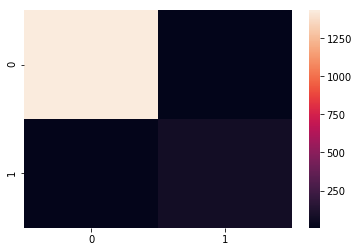

In [17]:
sns.heatmap(confusion_matrix(target_list, preds_list))
plt.show()

In [18]:
from sklearn.metrics import classification_report
print(classification_report(target_list, preds_list))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1439
           1       0.94      0.85      0.89        85

   micro avg       0.99      0.99      0.99      1524
   macro avg       0.96      0.92      0.94      1524
weighted avg       0.99      0.99      0.99      1524



## Load in test sets and create predictions

I have both a test set and holdout set that is blind; instead of combining the data, I'll run them sequentially and add predictions to a dataframe for submission.

In [19]:
holdout_loader = torch.utils.data.DataLoader(holdout_dataset, batch_size=batch_size, num_workers=num_workers)
comp_test_loader = torch.utils.data.DataLoader(comp_test_dataset, batch_size=batch_size, num_workers=num_workers)

In [20]:
##### predict holdout set #####
model.cuda()
model.eval() # eliminates dropout
preds = []
for data, target in holdout_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass
    output = model(data)
    preds.extend(output)
preds = torch.stack(preds)
holdout_preds = torch.exp(F.log_softmax(preds.cpu(), dim=1))
_, holdout_preds = torch.max(holdout_preds, 1)

In [21]:
holdout_probs = torch.exp(F.log_softmax(preds.cpu(), dim=1))[:,1]

In [22]:
##### predict competition test set #####
model.cuda()
model.eval() # eliminates dropout
comp_preds = []
for data, target in comp_test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass
    output = model(data)
    comp_preds.extend(output)
comp_preds = torch.stack(comp_preds)
comp_test_preds = torch.exp(F.log_softmax(comp_preds.cpu(), dim=1))
_, comp_test_preds = torch.max(comp_test_preds, 1)

In [23]:
comp_test_probs = torch.exp(F.log_softmax(comp_preds.cpu(), dim=1))[:,1]

In [24]:
# get fileids into list
holdout_fileid = os.listdir(holdout_image_dir + '1')
comp_test_fileid = os.listdir(test_image_dir + '1')
fileids = []
fileids.extend(holdout_fileid)
fileids.extend(comp_test_fileid)

In [25]:
# get predictions into list
has_oilpalm = []
has_oilpalm.extend(holdout_probs.detach().numpy())
has_oilpalm.extend(comp_test_probs.detach().numpy())

In [26]:
# prepare submission file for storing predictions
import pandas as pd
submission = pd.DataFrame(columns=['image_id', 'has_oilpalm'])
submission['image_id'] = fileids
submission['has_oilpalm'] = has_oilpalm

In [27]:
submission.describe()

,has_oilpalm
count,6534.000000
mean,0.180968
std,0.350614
min,0.000369
25%,0.003228
50%,0.006934
75%,0.052189
max,0.998857


In [28]:
submission.to_csv('subs/vgg16-5ximg-5ep-sgd01.csv', index=False)